In [2]:
:dep anyhow = "1.0.66"
:dep opencv = "0.70.0"
:dep image = "0.23"
:dep evcxr_image = "1.1.0"
:dep ndarray = "0.15.6"
:dep nalgebra = "0.31.2"
:dep cv-convert = { version = "0.21.2", features=["opencv_0-70", "image_0-23", "nalgebra_0-31", "ndarray_0-15"] }

use std::fs;
use std::path::{Path};
use anyhow::{anyhow, Result, Error};
use opencv::prelude::*;
use cv_convert::{FromCv, IntoCv, TryFromCv, TryIntoCv};
use image::{ImageBuffer, RgbImage, Rgb};
use evcxr_image::ImageDisplay;

#[macro_use]
extern crate nalgebra as na;

fn opencv_imshow(img: &Mat) {
    let img_rgb = RgbImage::new(img.cols() as u32, img.rows() as u32);
    let data: Vec<u8> = img.data_bytes().unwrap().to_vec();
    let channels: u32 = img.channels() as u32;
    image::ImageBuffer::from_fn(img_rgb.width(), img_rgb.height(), | x, y | {
        let yi = y * img_rgb.width();
        let i: usize = ((x + yi) * channels) as usize;
        match channels {
            3 => {
                let b = data[i];
                let g = data[i + 1];
                let r = data[i + 2];
                image::Rgb([r, g, b])
            },
            _ => {
                let b = data[i];
                image::Rgb([b, b, b])
            }
        }
    }).evcxr_display()
}

let image_dir = "images";

# Hessian Corner Detector

Mat { type: "CV_8UC1", flags: 1124024320, channels: 1, depth: "CV_8U", dims: 2, size: Size_ { width: 900, height: 1200 }, rows: 1200, cols: 900, elem_size: 1, elem_size1: 1, total: 1080000, is_continuous: true, is_submatrix: false }


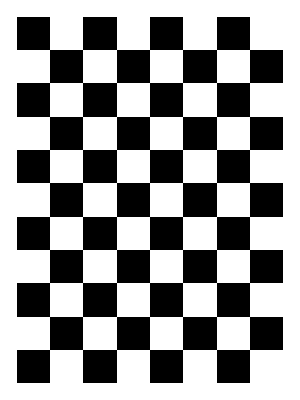

In [3]:
let image_path = Path::new(image_dir).join("checkerboard.png");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_GRAYSCALE)?;
println!("{:?}", &img);
let mut img_resized: Mat = Default::default();
opencv::imgproc::resize(
    &img,
    &mut img_resized,
    opencv::core::Size::new(300, 400),
    0., // fx. default 0.
    0., // fy. default 0.
    opencv::imgproc::INTER_LINEAR as i32
);
opencv_imshow(&img_resized)

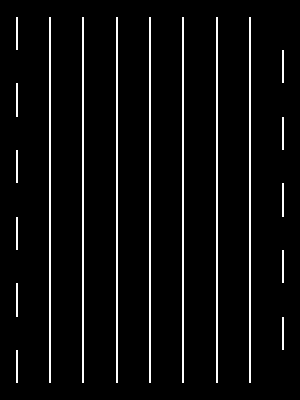

In [4]:
let mut img_filter2d_Ixx: Mat = Default::default();
let kernel_Ixx: Mat = Mat::from_slice_2d(&[[0. as f32, 0., 0.], [1., -2., 1.], [0., 0., 0.]]).unwrap();
opencv::imgproc::filter_2d(
    &img_resized,
    &mut img_filter2d_Ixx,
    opencv::core::CV_32FC1,
    &kernel_Ixx,
    opencv::core::Point::new(-1, -1),
    0.,
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_filter2d_Ixx_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_Ixx, &mut img_filter2d_Ixx_abs, 1., 0.);
opencv_imshow(&img_filter2d_Ixx_abs)

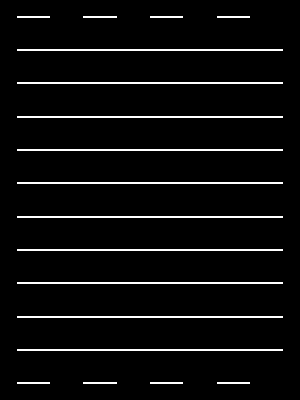

In [5]:
let mut img_filter2d_Iyy: Mat = Default::default();
let kernel_Iyy: Mat = Mat::from_slice_2d(&[[0. as f32, 1., 0.], [0., -2., 0.], [0., 1., 0.]]).unwrap();
opencv::imgproc::filter_2d(
    &img_resized,
    &mut img_filter2d_Iyy,
    opencv::core::CV_32FC1,
    &kernel_Iyy,
    opencv::core::Point::new(-1, -1),
    0.,
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_filter2d_Iyy_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_Iyy, &mut img_filter2d_Iyy_abs, 1., 0.);
opencv_imshow(&img_filter2d_Iyy_abs)

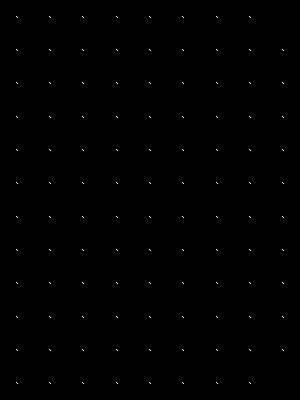

In [6]:
let mut img_filter2d_Ixy: Mat = Default::default();
let kernel_Ixy: Mat = Mat::from_slice_2d(&[[1. as f32, -1., 0.], [-1., 2., -1.], [0., -1., 1.]]).unwrap();
opencv::imgproc::filter_2d(
    &img_resized,
    &mut img_filter2d_Ixy,
    opencv::core::CV_32FC1,
    &kernel_Ixy,
    opencv::core::Point::new(-1, -1),
    0.,
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_filter2d_Ixy_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_Ixy, &mut img_filter2d_Ixy_abs, 1., 0.);
opencv_imshow(&img_filter2d_Ixy_abs)

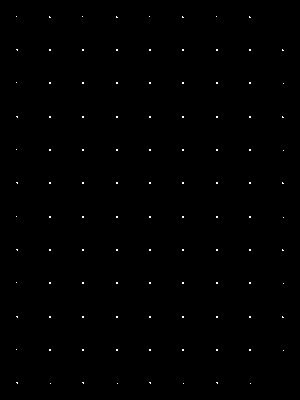

In [7]:
// same as img_filter2d_Ixx_abs*img_filter2d_Iyy_abs - img_filter2d_Ixy_abs**2
let mut img_filter2d_Ixxyy_multi: Mat = Default::default();
opencv::core::multiply(&img_filter2d_Ixx, &img_filter2d_Iyy, &mut img_filter2d_Ixxyy_multi, 1., -1);

let mut img_filter2d_Ixy_pow: Mat = Default::default();
opencv::core::multiply(&img_filter2d_Ixy, &img_filter2d_Ixy, &mut img_filter2d_Ixy_pow, 1., -1);

let mut img_filter2d_detH: Mat = Default::default();
opencv::core::subtract(
    &img_filter2d_Ixxyy_multi,
    &img_filter2d_Ixy_pow,
    &mut img_filter2d_detH,
    &opencv::core::no_array(),
    -1
);
let mut img_filter2d_detH_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_detH, &mut img_filter2d_detH_abs, 1., 0.);
opencv_imshow(&img_filter2d_detH_abs)

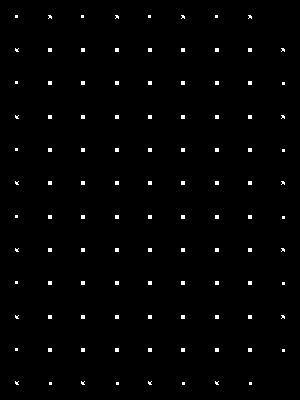

In [8]:
let mut img_filter2d_corner: Mat = Default::default();
let kernel_corner: Mat = Mat::from_slice_2d(&[[-1. as f32, -1., -1.], [-1., 8., -1.], [-1., -1., -1.]]).unwrap();
opencv::imgproc::filter_2d(
    &img_filter2d_detH,
    &mut img_filter2d_corner,
    opencv::core::CV_32FC1,
    &kernel_corner,
    opencv::core::Point::new(-1, -1),
    0.,
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_filter2d_corner_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_filter2d_corner, &mut img_filter2d_corner_abs, 1., 0.);
opencv_imshow(&img_filter2d_corner_abs)

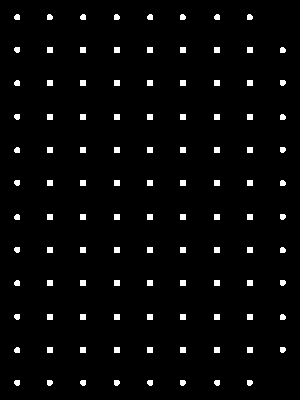

In [9]:
let mut img_resized_f32: Mat = Default::default();
img_resized.convert_to(&mut img_resized_f32, opencv::core::CV_32FC1, 1., 0.);
let mut img_corner_harris: Mat = Default::default();
opencv::imgproc::corner_harris(
    &img_resized_f32,
    &mut img_corner_harris,
    3, // block_size
    3, // ksize
    0.04, //k
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);
let mut img_corner_harris_dilate: Mat = Default::default();
opencv::imgproc::dilate(
    &img_corner_harris,
    &mut img_corner_harris_dilate,
    &opencv::core::no_array(),
    opencv::core::Point::new(-1, -1),
    1, 0, Default::default()
);
let mut img_corner_harris_dilate_bin: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_corner_harris_dilate,
    &mut img_corner_harris_dilate_bin,
    0., 255., opencv::imgproc::THRESH_BINARY).expect("threshold failed.");

let mut img_corner_harris_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_corner_harris_dilate_bin, &mut img_corner_harris_abs, 1., 0.);
opencv_imshow(&img_corner_harris_abs)

# Harris Corner Detector

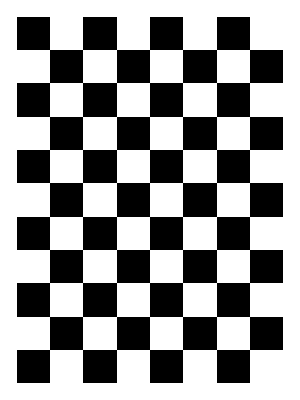

In [10]:
opencv_imshow(&img_resized)

max: 458335776.0 / min: -169130032.0


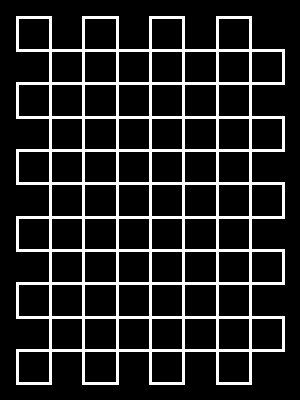

In [11]:
let mut img_resized_f32: Mat = Default::default();
img_resized.convert_to(&mut img_resized_f32, opencv::core::CV_32FC1, 1., 0.);
let mut img_corner_harris: Mat = Default::default();
opencv::imgproc::corner_harris(
    &img_resized_f32,
    &mut img_corner_harris,
    2, // block_size
    3, // ksize
    0.04, //k
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);

let mut img_corner_harris_min: f64 = Default::default();
let img_corner_harris_min_containter = Some(&mut img_corner_harris_min);
let mut img_corner_harris_max: f64 = Default::default();
let img_corner_harris_max_containter = Some(&mut img_corner_harris_max);
opencv::core::min_max_loc(
    &img_corner_harris,
    img_corner_harris_min_containter,
    img_corner_harris_max_containter,
    None,
    None,
    &opencv::core::no_array()
);
println!("max: {:?} / min: {:?}", &img_corner_harris_max, img_corner_harris_min);

let mut img_corner_harris_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_corner_harris, &mut img_corner_harris_abs, 1., 0.);
opencv_imshow(&img_corner_harris_abs)

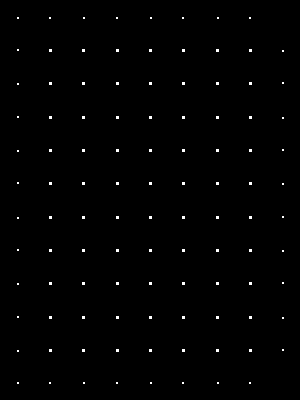

In [12]:
let mut img_corner_harris_bin: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_corner_harris,
    &mut img_corner_harris_bin,
    img_corner_harris_max * 0.01, 255., opencv::imgproc::THRESH_BINARY).expect("threshold failed.");
let mut img_corner_harris_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_corner_harris_bin, &mut img_corner_harris_abs, 1., 0.);
opencv_imshow(&img_corner_harris_abs)

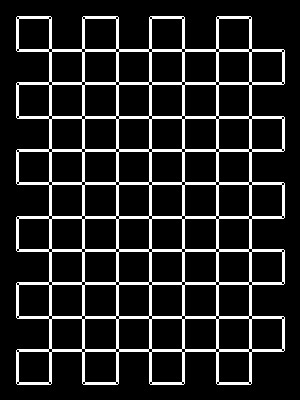

In [13]:
let mut img_corner_harris_bin_inv: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_corner_harris,
    &mut img_corner_harris_bin_inv,
    img_corner_harris_min * 0.01, 255., opencv::imgproc::THRESH_BINARY_INV).expect("threshold failed.");
let mut img_corner_harris_bin_inv_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_corner_harris_bin_inv, &mut img_corner_harris_bin_inv_abs, 1., 0.);
opencv_imshow(&img_corner_harris_bin_inv_abs)

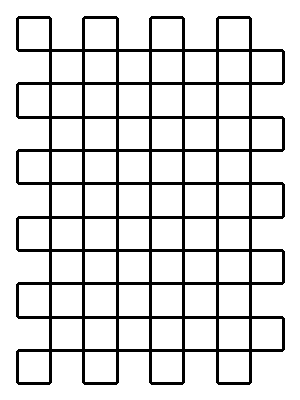

In [14]:
let img_corner_harris_flattened_raw: Vec<f32> = img_corner_harris.reshape(1, 1).unwrap().to_vec_2d::<f32>().unwrap().get(0).unwrap().to_owned();
let mut img_corner_harris_na_matrix: na::base::DMatrix<f32> = na::base::DMatrix::from_vec(
    img_corner_harris.cols() as usize,
    img_corner_harris.rows() as usize,
    img_corner_harris_flattened_raw);
let img_corner_harris_na_matrix_abs_f32: na::base::OMatrix<f32, na::base::Dynamic, na::base::Dynamic> = img_corner_harris_na_matrix.abs();
let img_corner_harris_abs_mat: Mat = img_corner_harris_na_matrix_abs_f32.try_into_cv().unwrap();
// flip and roate image
let mut img_corner_harris_abs_mat_flipped: Mat = Default::default();
opencv::core::flip(&img_corner_harris_abs_mat, &mut img_corner_harris_abs_mat_flipped, 0)?;
let mut img_corner_harris_abs_mat_flipped_rotated: Mat = Default::default();
opencv::core::rotate(&img_corner_harris_abs_mat_flipped, &mut img_corner_harris_abs_mat_flipped_rotated, opencv::core::ROTATE_90_CLOCKWISE)?;

let mut img_corner_harris_bin_final: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_corner_harris_abs_mat_flipped_rotated,
    &mut img_corner_harris_bin_final,
    img_corner_harris_max * 0.01, 255., opencv::imgproc::THRESH_BINARY_INV).expect("threshold failed.");
let mut img_corner_harris_bin_final_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_corner_harris_bin_final, &mut img_corner_harris_bin_final_abs, 1., 0.);
opencv_imshow(&img_corner_harris_bin_final_abs)

# Hessian and Harris Corner

Mat { type: "CV_8UC1", flags: 1124024320, channels: 1, depth: "CV_8U", dims: 2, size: Size_ { width: 500, height: 375 }, rows: 375, cols: 500, elem_size: 1, elem_size1: 1, total: 187500, is_continuous: true, is_submatrix: false }


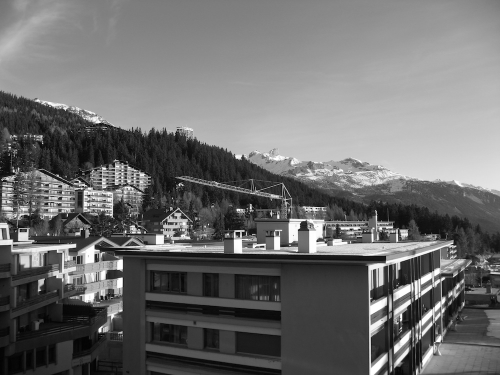

In [15]:
let image_path = Path::new(image_dir).join("crans_1_small.jpg");
let img_crans: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_GRAYSCALE)?;
let mut img_crans_resized: Mat = Default::default();
opencv::imgproc::resize(
    &img_crans,
    &mut img_crans_resized,
    opencv::core::Size::new(img_crans.cols() / 2, img_crans.rows() / 2),
    0., // fx. default 0.
    0., // fy. default 0.
    opencv::imgproc::INTER_LINEAR as i32
);
println!("{:?}", &img_crans_resized);
opencv_imshow(&img_crans_resized)

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 500, height: 375 }, rows: 375, cols: 500, elem_size: 4, elem_size1: 4, total: 187500, is_continuous: true, is_submatrix: false }


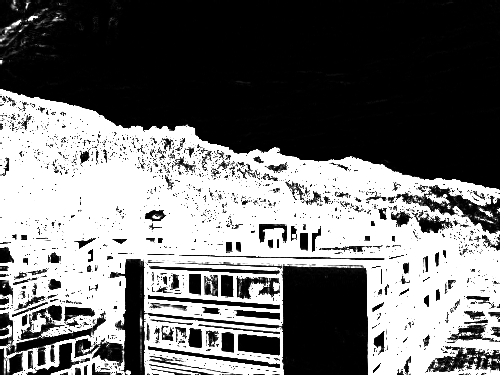

In [16]:
let mut img_crans_resized_f32: Mat = Default::default();
img_crans_resized.convert_to(&mut img_crans_resized_f32, opencv::core::CV_32FC1, 1., 0.);
println!("{:?}", &img_crans_resized_f32);
let mut img_crans_corner_harris: Mat = Default::default();
opencv::imgproc::corner_harris(
    &img_crans_resized_f32,
    &mut img_crans_corner_harris,
    2, // block_size
    3, // ksize
    0.04, //k
    opencv::core::BorderTypes::BORDER_REFLECT_101 as i32
);

let mut img_crans_corner_harris_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_crans_corner_harris, &mut img_crans_corner_harris_abs, 1., 0.);
opencv_imshow(&img_crans_corner_harris_abs)

In [17]:
let mut img_crans_corner_harris_min: f64 = Default::default();
let img_crans_corner_harris_min_containter = Some(&mut img_crans_corner_harris_min);
let mut img_crans_corner_harris_max: f64 = Default::default();
let img_crans_corner_harris_max_containter = Some(&mut img_crans_corner_harris_max);
opencv::core::min_max_loc(
    &img_crans_corner_harris,
    img_crans_corner_harris_min_containter,
    img_crans_corner_harris_max_containter,
    None,
    None,
    &opencv::core::no_array()
);
println!("min: {:?}", &img_crans_corner_harris_min);
println!("max: {:?}", &img_crans_corner_harris_max);

min: -62114668.0
max: 132259176.0


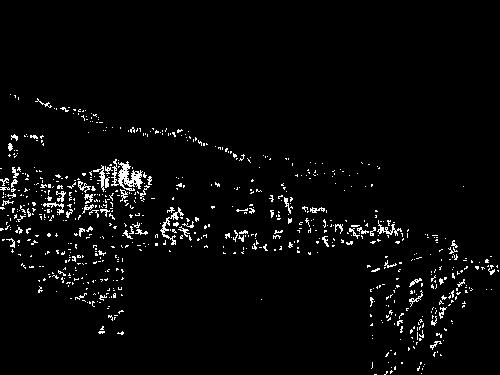

In [18]:
let mut img_crans_corner_harris_max_bin: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_crans_corner_harris,
    &mut img_crans_corner_harris_max_bin,
    &img_crans_corner_harris_max * 0.01, 255., opencv::imgproc::THRESH_BINARY).expect("threshold failed.");

let mut img_crans_corner_harris_max_bin_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_crans_corner_harris_max_bin, &mut img_crans_corner_harris_max_bin_abs, 1., 0.);
opencv_imshow(&img_crans_corner_harris_max_bin_abs)

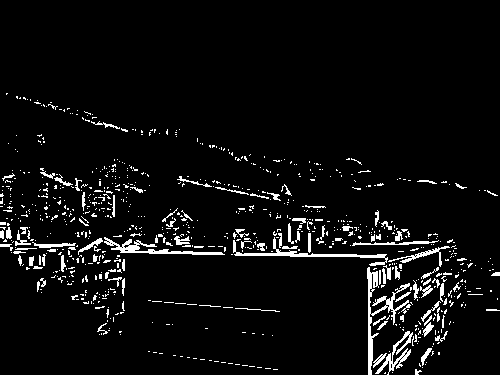

In [19]:
let mut img_crans_corner_harris_min_bin: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_crans_corner_harris,
    &mut img_crans_corner_harris_min_bin,
    &img_crans_corner_harris_min * 0.01, 255., opencv::imgproc::THRESH_BINARY_INV).expect("threshold failed.");

let mut img_crans_corner_harris_min_bin_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_crans_corner_harris_min_bin, &mut img_crans_corner_harris_min_bin_abs, 1., 0.);
opencv_imshow(&img_crans_corner_harris_min_bin_abs)

max: 132259176.0 / min: 0.0


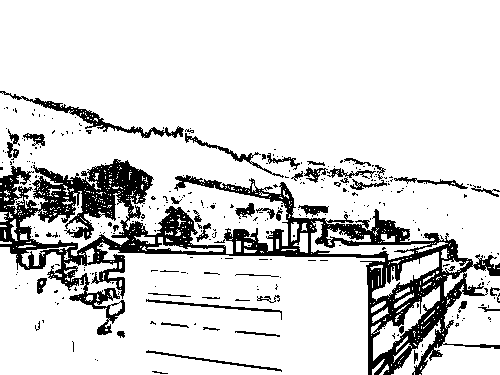

In [20]:
let img_crans_corner_harris_flattened_raw: Vec<f32> = img_crans_corner_harris.reshape(1, 1).unwrap().to_vec_2d::<f32>().unwrap().get(0).unwrap().to_owned();
// println!("flatten: {:?}", &img_crans_corner_harris_flattened_raw);
// flatten: [2.9267187, 2.9267187, 5.446328, 5.0127344, 1.6971095, 0.36207038, 13.16832, 5.1125393, 3.2144146, 6.9708605, 5.82125, 6.8475, 28.104649, 146.28207, 176.17676, 77.04297, 26.04184, -16.149372, -18.085781, -3.485117, 0.20914078, 0.54664063, 2.196289, 11.774844, 7.5451565, -8.103358, 43.848206, 80.65903, 67.60765, 36.30172, 13.4765625, 0.18687534, -0.4423437, -0.859375, -1.1655858, 3.5302343, 3.6666408, 10.295469...]
let mut img_crans_corner_harris_na_matrix: na::base::DMatrix<f32> = na::base::DMatrix::from_vec(
    img_crans_corner_harris.cols() as usize,
    img_crans_corner_harris.rows() as usize,
    img_crans_corner_harris_flattened_raw);
// println!("na: {:?}", &img_crans_corner_harris_na_matrix);
// na: [2.9267187, 2.9267187, 5.446328, 5.0127344, 1.6971095, 0.36207038, 13.16832, 5.1125393, 3.2144146, 6.9708605, 5.82125, 6.8475, 28.104649, 146.28207, 176.17676, 77.04297, 26.04184, -16.149372, -18.085781, -3.485117, 0.20914078, 0.54664063, 2.196289, 11.774844, 7.5451565, -8.103358, 43.848206, 80.65903, 67.60765, 36.30172, 13.4765625, 0.18687534, -0.4423437, -0.859375, -1.1655858, 3.5302343, 3.6666408, 10.295469...]

let img_crans_corner_harris_abs_f32: na::base::OMatrix<f32, na::base::Dynamic, na::base::Dynamic> = img_crans_corner_harris_na_matrix.abs();
// println!("{:?}", &img_crans_corner_harris_abs_f32);
// abs: [2.9267187, 2.9267187, 5.446328, 5.0127344, 1.6971095, 0.36207038, 13.16832, 5.1125393, 3.2144146, 6.9708605, 5.82125, 6.8475, 28.104649, 146.28207, 176.17676, 77.04297, 26.04184, 16.149372, 18.085781, 3.485117, 0.20914078, 0.54664063, 2.196289, 11.774844, 7.5451565, 8.103358, 43.848206, 80.65903, 67.60765, 36.30172, 13.4765625, 0.18687534, 0.4423437, 0.859375, 1.1655858, 3.5302343, 3.6666408, 10.295469...]
let img_crans_corner_harris_abs_f32_max: f64 = img_crans_corner_harris_abs_f32.max() as f64;
println!("max: {:?} / min: {:?}", &img_crans_corner_harris_abs_f32.max(), &img_crans_corner_harris_abs_f32.min());
let img_carns_corner_harris_abs_mat: Mat = img_crans_corner_harris_abs_f32.try_into_cv().unwrap();
// println!("{:?}", img_carns_corner_harris_abs_mat.reshape(1, 1).unwrap().to_vec_2d::<f32>().unwrap().get(0).unwrap().to_owned());
// mat: [2.9267187, 2.9267187, 3.3035548, 1.7660547, 0.5290625, 0.094375, 2.0751953, 0.5847266, 0.0036718752, 0.1646875, 0.3125, 0.07210938, 0.080507815, 0.16859375, 0.29296875, 0.48140627, 4.242031, 5.146719, 0.9473047, 0.016250134, 3.5549216, 0.68335927, 0.24222657, 1.5150782, 2.0862892, 0.031484365, 1.3154688, 7.5182033, 30.24086, 57.241447, 73.29098, 75.64195, 47.11035, 26.42973, 0.55843353, 36.265625, 65.59515...]
// na::try_into_cv rotate matrix.

let mut img_crans_corner_harris_final_bin: Mat = Default::default();
let _ = opencv::imgproc::threshold(
    &img_carns_corner_harris_abs_mat,
    &mut img_crans_corner_harris_final_bin,
    img_crans_corner_harris_abs_f32_max * 0.001, 255., opencv::imgproc::THRESH_BINARY_INV).expect("threshold failed.");

let mut img_crans_corner_harris_final_bin_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&img_crans_corner_harris_final_bin, &mut img_crans_corner_harris_final_bin_abs, 1., 0.);

// flip and roate image
let mut img_crans_corner_harris_final_bin_abs_flipped: Mat = Default::default();
opencv::core::flip(&img_crans_corner_harris_final_bin_abs, &mut img_crans_corner_harris_final_bin_abs_flipped, 0)?;
let mut img_crans_corner_harris_final_bin_abs_flipped_rotated: Mat = Default::default();
opencv::core::rotate(&img_crans_corner_harris_final_bin_abs_flipped, &mut img_crans_corner_harris_final_bin_abs_flipped_rotated, opencv::core::ROTATE_90_CLOCKWISE)?;
opencv_imshow(&img_crans_corner_harris_final_bin_abs_flipped_rotated)

# FAST Corner Detector

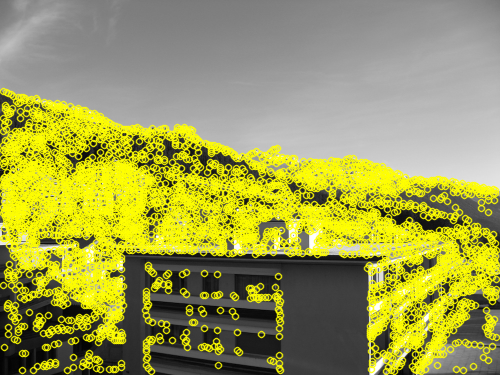

In [21]:
let mut fast_threshold: i32 = 10;
let mut fast_keypoints: opencv::core::Vector<opencv::core::KeyPoint> = Default::default();
opencv::features2d::FAST(
    &img_crans_resized,
    &mut fast_keypoints,
    fast_threshold,
    true // default
);
let mut img_crans_keypoint_render: Mat = Default::default();
opencv::features2d::draw_keypoints(
    &img_crans_resized,
    &fast_keypoints,
    &mut img_crans_keypoint_render,
    opencv::core::Scalar::new(0.0, 255.0, 255.0, 100.0),
    opencv::features2d::DrawMatchesFlags::DEFAULT
);
opencv_imshow(&img_crans_keypoint_render)

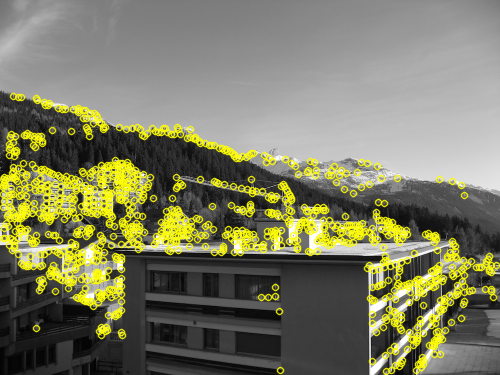

In [22]:
let mut fast_threshold: i32 = 50;
let mut fast_keypoints: opencv::core::Vector<opencv::core::KeyPoint> = Default::default();
opencv::features2d::FAST(
    &img_crans_resized,
    &mut fast_keypoints,
    fast_threshold,
    true // default
);
let mut img_crans_keypoint_render: Mat = Default::default();
opencv::features2d::draw_keypoints(
    &img_crans_resized,
    &fast_keypoints,
    &mut img_crans_keypoint_render,
    opencv::core::Scalar::new(0.0, 255.0, 255.0, 100.0),
    opencv::features2d::DrawMatchesFlags::DEFAULT
);
opencv_imshow(&img_crans_keypoint_render)

# SIFT

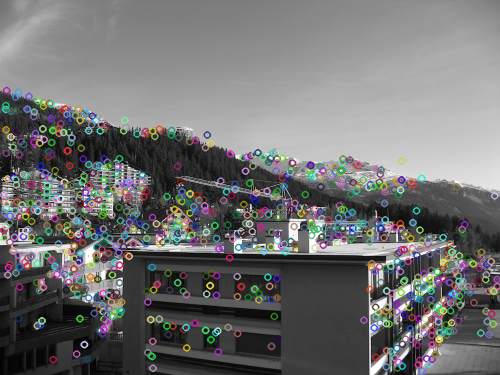

In [23]:
let mut sift_keypoints: opencv::core::Vector<opencv::core::KeyPoint> = Default::default();
let mut sift: opencv::core::Ptr<opencv::features2d::SIFT> = opencv::features2d::SIFT::create(
    0,
    3,
    0.04,
    10.,
    1.6
).unwrap(); // all default
sift.detect(
    &img_crans_resized,
    &mut sift_keypoints,
    &opencv::core::no_array()
);
let mut img_crans_keypoint_render: Mat = Default::default();
opencv::features2d::draw_keypoints(
    &img_crans_resized,
    &sift_keypoints,
    &mut img_crans_keypoint_render,
    opencv::core::Scalar::all(-1.),
    opencv::features2d::DrawMatchesFlags::DEFAULT
);
opencv_imshow(&img_crans_keypoint_render)

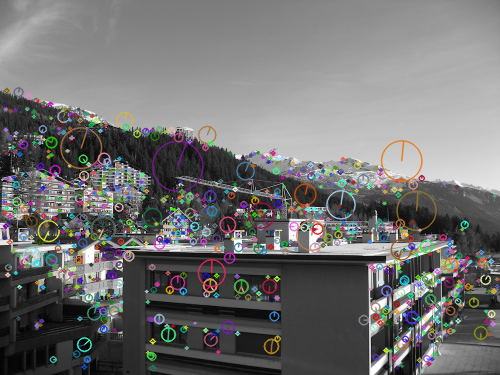

In [24]:
opencv::features2d::draw_keypoints(
    &img_crans_resized,
    &sift_keypoints,
    &mut img_crans_keypoint_render,
    opencv::core::Scalar::all(-1.),
    opencv::features2d::DrawMatchesFlags::DRAW_RICH_KEYPOINTS
);
opencv_imshow(&img_crans_keypoint_render)

# SURF

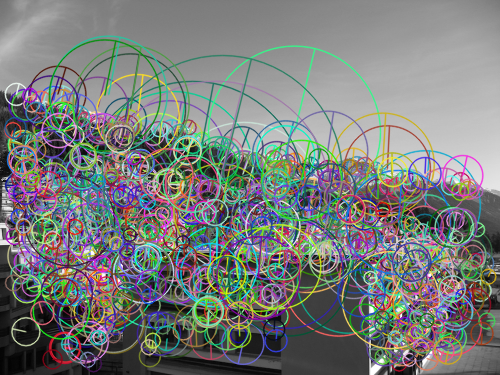

In [25]:
let mut surf_keypoints: opencv::core::Vector<opencv::core::KeyPoint> = Default::default();
let mut surf: opencv::core::Ptr<dyn opencv::xfeatures2d::SURF> = opencv::xfeatures2d::SurfFeatureDetector::create
(
    500., // hessian threshold
    4,
    3,
    false,
    false
).unwrap();
surf.detect_and_compute(
    &img_crans_resized,
    &mut opencv::core::no_array(),
    &mut surf_keypoints,
    &mut opencv::core::no_array(),
    false
);
opencv::features2d::draw_keypoints(
    &img_crans_resized,
    &surf_keypoints,
    &mut img_crans_keypoint_render,
    opencv::core::Scalar::all(-1.),
    opencv::features2d::DrawMatchesFlags::DRAW_RICH_KEYPOINTS
);
opencv_imshow(&img_crans_keypoint_render)

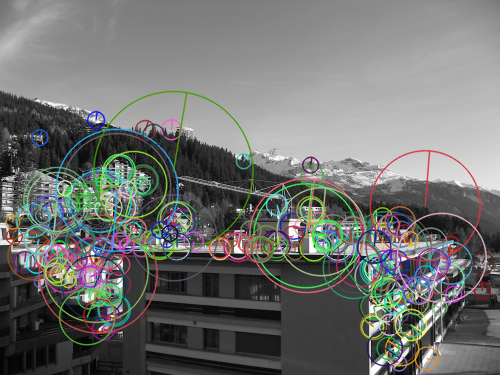

In [26]:
let mut surf_keypoints: opencv::core::Vector<opencv::core::KeyPoint> = Default::default();
let mut surf: opencv::core::Ptr<dyn opencv::xfeatures2d::SURF> = opencv::xfeatures2d::SurfFeatureDetector::create
(
    5000., // hessian threshold
    4,
    3,
    false,
    false
).unwrap();
surf.detect_and_compute(
    &img_crans_resized,
    &mut opencv::core::no_array(),
    &mut surf_keypoints,
    &mut opencv::core::no_array(),
    false
);
opencv::features2d::draw_keypoints(
    &img_crans_resized,
    &surf_keypoints,
    &mut img_crans_keypoint_render,
    opencv::core::Scalar::all(-1.),
    opencv::features2d::DrawMatchesFlags::DRAW_RICH_KEYPOINTS
);
opencv_imshow(&img_crans_keypoint_render)

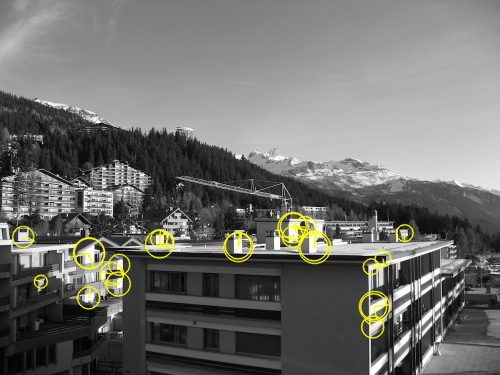

In [27]:
let mut surf_keypoints: opencv::core::Vector<opencv::core::KeyPoint> = Default::default();
let mut surf: opencv::core::Ptr<dyn opencv::xfeatures2d::SURF> = opencv::xfeatures2d::SurfFeatureDetector::create
(
    20000., // hessian threshold
    4,
    3,
    false,
    false
).unwrap();
surf.detect_and_compute(
    &img_crans_resized,
    &mut opencv::core::no_array(),
    &mut surf_keypoints,
    &mut opencv::core::no_array(),
    false
);
opencv::features2d::draw_keypoints(
    &img_crans_resized,
    &surf_keypoints,
    &mut img_crans_keypoint_render,
    opencv::core::Scalar::new(0.0, 255.0, 255.0, 100.0),
    opencv::features2d::DrawMatchesFlags::DRAW_RICH_KEYPOINTS
);
opencv_imshow(&img_crans_keypoint_render)

# Find Corresponding Keypoints

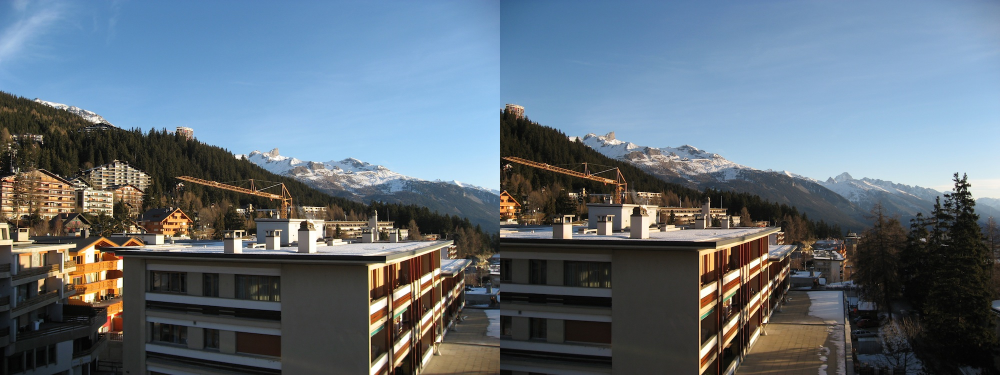

In [28]:
let image_path = Path::new(image_dir).join("crans_1_small.jpg");
let img_l: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_UNCHANGED)?;
let mut img_l_resized: Mat = Default::default();
opencv::imgproc::resize(
    &img_l,
    &mut img_l_resized,
    opencv::core::Size::new(img_l.cols() / 2, img_l.rows() / 2),
    0., // fx. default 0.
    0., // fy. default 0.
    opencv::imgproc::INTER_LINEAR as i32
);
let mut gray_l: Mat = Default::default();
opencv::imgproc::cvt_color(&img_l_resized, &mut gray_l, opencv::imgproc::COLOR_BGR2GRAY, 0).expect("error on cvt_color");

let image_path = Path::new(image_dir).join("crans_2_small.jpg");
let img_r: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_UNCHANGED)?;
let mut img_r_resized: Mat = Default::default();
opencv::imgproc::resize(
    &img_r,
    &mut img_r_resized,
    opencv::core::Size::new(img_r.cols() / 2, img_r.rows() / 2),
    0., // fx. default 0.
    0., // fy. default 0.
    opencv::imgproc::INTER_LINEAR as i32
);
let mut gray_r: Mat = Default::default();
opencv::imgproc::cvt_color(&img_r_resized, &mut gray_r, opencv::imgproc::COLOR_BGR2GRAY, 0).expect("error on cvt_color");

let mut img_lr: opencv::core::Vector<Mat> = opencv::types::VectorOfMat::new();
img_lr.push(img_l_resized.clone());
img_lr.push(img_r_resized.clone());
let mut img_lr_concat: Mat = Default::default();
opencv::core::hconcat(&img_lr, &mut img_lr_concat).expect("error on concat");
opencv_imshow(&img_lr_concat)

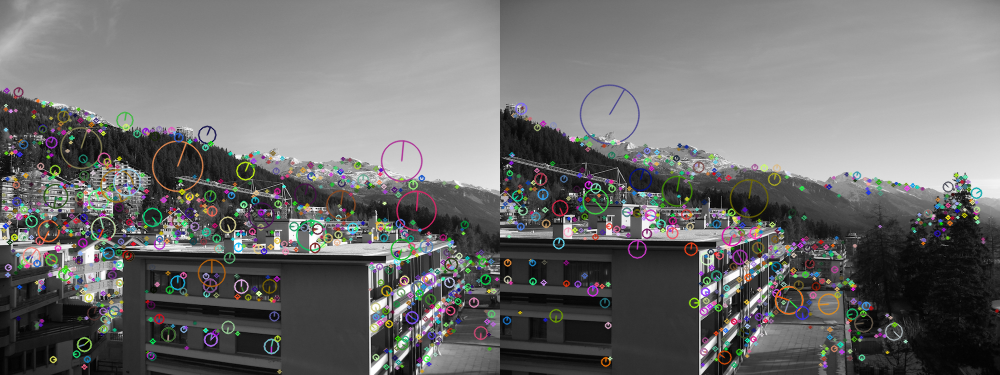

In [29]:
let mut gray_l_sift_keypoints: opencv::core::Vector<opencv::core::KeyPoint> = Default::default();
let mut gray_l_sift_descriptors: Mat = Default::default();
let mut gray_r_sift_keypoints: opencv::core::Vector<opencv::core::KeyPoint> = Default::default();
let mut gray_r_sift_descriptors: Mat = Default::default();

let mut sift_extractor: opencv::core::Ptr<opencv::features2d::SIFT> = opencv::features2d::SIFT::create(
    0,
    3,
    0.04,
    10.,
    1.6
).unwrap(); // all default

sift_extractor.detect_and_compute(
    &gray_l,
    &opencv::core::no_array(),
    &mut gray_l_sift_keypoints,
    &mut gray_l_sift_descriptors,
    false
);
sift_extractor.detect_and_compute(
    &gray_r,
    &opencv::core::no_array(),
    &mut gray_r_sift_keypoints,
    &mut gray_r_sift_descriptors,
    false
);

let mut gray_l_keypoint_render: Mat = Default::default();
let mut gray_r_keypoint_render: Mat = Default::default();
opencv::features2d::draw_keypoints(
    &gray_l, // panic with non-u8 image
    &gray_l_sift_keypoints,
    &mut gray_l_keypoint_render,
    opencv::core::Scalar::all(-1.),
    opencv::features2d::DrawMatchesFlags::DRAW_RICH_KEYPOINTS
);
opencv::features2d::draw_keypoints(
    &gray_r, // panic with non-u8 image
    &gray_r_sift_keypoints,
    &mut gray_r_keypoint_render,
    opencv::core::Scalar::all(-1.),
    opencv::features2d::DrawMatchesFlags::DRAW_RICH_KEYPOINTS
);

let mut gray_lr_keypointed: opencv::core::Vector<Mat> = opencv::types::VectorOfMat::new();
gray_lr_keypointed.push(gray_l_keypoint_render.clone());
gray_lr_keypointed.push(gray_r_keypoint_render.clone());
let mut gray_lr_keypointed_concat: Mat = Default::default();
opencv::core::hconcat(&gray_lr_keypointed, &mut gray_lr_keypointed_concat).expect("error on concat");
opencv_imshow(&gray_lr_keypointed_concat)

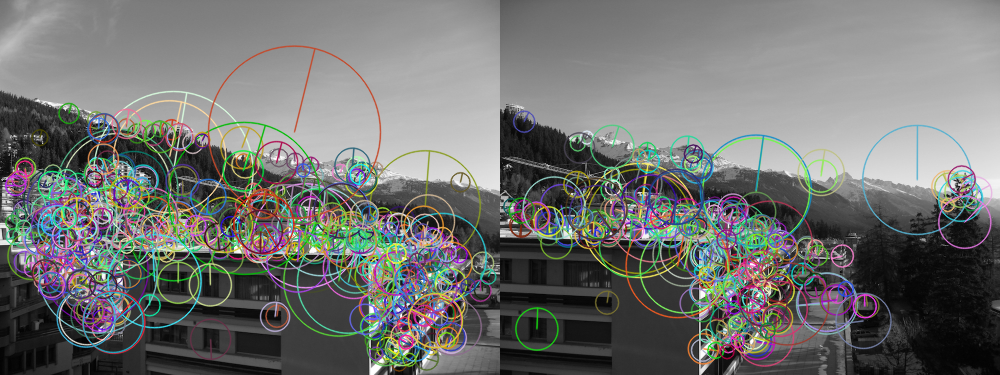

In [30]:
let mut gray_l_surf_keypoints: opencv::core::Vector<opencv::core::KeyPoint> = Default::default();
let mut gray_l_surf_descriptors: Mat = Default::default();
let mut gray_r_surf_keypoints: opencv::core::Vector<opencv::core::KeyPoint> = Default::default();
let mut gray_r_surf_descriptors: Mat = Default::default();

let mut surf: opencv::core::Ptr<dyn opencv::xfeatures2d::SURF> = opencv::xfeatures2d::SurfFeatureDetector::create
(
    2000., // hessian threshold
    4,
    3,
    false,
    false
).unwrap();

surf.detect_and_compute(
    &gray_l,
    &mut opencv::core::no_array(), // mask
    &mut gray_l_surf_keypoints, // keypoints
    &mut gray_l_surf_descriptors, // descriptors
    false // use_provided_keypoints
);
surf.detect_and_compute(
    &gray_r,
    &mut opencv::core::no_array(), // mask
    &mut gray_r_surf_keypoints, // keypoints
    &mut gray_r_surf_descriptors, // descriptors
    false // use_provided_keypoints
);

let mut gray_l_keypoint_render: Mat = Default::default();
let mut gray_r_keypoint_render: Mat = Default::default();
opencv::features2d::draw_keypoints(
    &gray_l,
    &gray_l_surf_keypoints,
    &mut gray_l_keypoint_render,
    opencv::core::Scalar::all(-1.),
    opencv::features2d::DrawMatchesFlags::DRAW_RICH_KEYPOINTS
);
opencv::features2d::draw_keypoints(
    &gray_r,
    &gray_r_surf_keypoints,
    &mut gray_r_keypoint_render,
    opencv::core::Scalar::all(-1.),
    opencv::features2d::DrawMatchesFlags::DRAW_RICH_KEYPOINTS
);

let mut gray_lr_keypointed: opencv::core::Vector<Mat> = opencv::types::VectorOfMat::new();
gray_lr_keypointed.push(gray_l_keypoint_render.clone());
gray_lr_keypointed.push(gray_r_keypoint_render.clone());
let mut gray_lr_keypointed_concat: Mat = Default::default();
opencv::core::hconcat(&gray_lr_keypointed, &mut gray_lr_keypointed_concat).expect("error on concat");
opencv_imshow(&gray_lr_keypointed_concat)

524


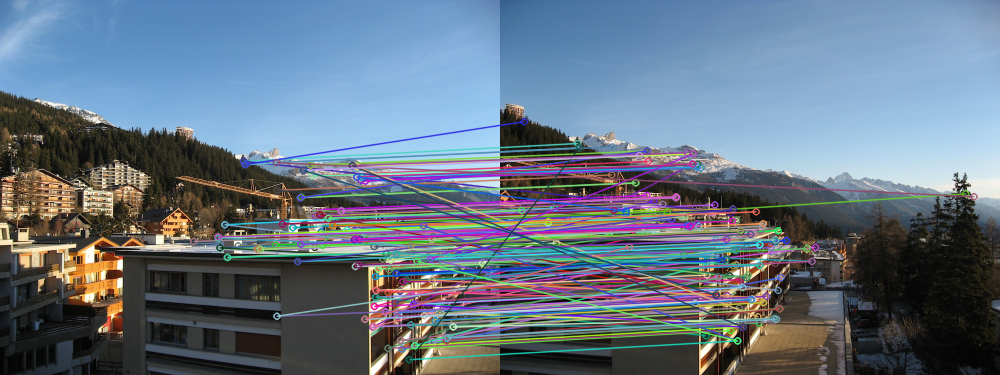

In [31]:
// BFMatcher: Brute-force descriptor matcher
let mut query_set: opencv::core::Vector<Mat> = Default::default();
query_set.push(gray_l_surf_descriptors.clone());
query_set.push(gray_r_surf_descriptors.clone());
let mut matches: opencv::core::Vector<opencv::core::Vector<opencv::core::DMatch>> = Default::default();
// let mut matches: opencv::core::Vector<opencv::core::DMatch> = Default::default();
let mut bf_matcher: opencv::core::Ptr<opencv::features2d::BFMatcher> = opencv::features2d::BFMatcher::create(
    opencv::core::NORM_L2, // default. block formula
    false // cross-check
).unwrap();
bf_matcher.knn_train_match(
    &gray_l_surf_descriptors,
    &gray_r_surf_descriptors,
    &mut matches,
    2, // k
    &opencv::core::no_array(),
    false // compact_result
);

fn good_match(matches: &opencv::core::Vector<opencv::core::Vector<opencv::core::DMatch>>)
    -> opencv::core::Vector<opencv::core::Vector<opencv::core::DMatch>> {
        let mut result: opencv::core::Vector<opencv::core::Vector<opencv::core::DMatch>> = Default::default();
        for m in matches {
            if ((m.get(0).unwrap().distance / m.get(1).unwrap().distance) < 0.5) {
                result.push(m);
            }
        }
        result
}
let good: opencv::core::Vector<opencv::core::Vector<opencv::core::DMatch>> = good_match(&matches);
println!("{:?}", good.len());

let mut img_lr_knn_match_render: Mat = Default::default();
let match_mask: opencv::core::Vector<opencv::core::Vector<i8>> = Default::default();
opencv::features2d::draw_matches_knn(
    &img_l_resized,
    &gray_l_surf_keypoints,
    &img_r_resized,
    &gray_r_surf_keypoints,
    &good,
    &mut img_lr_knn_match_render,
    opencv::core::Scalar::all(-1.), // match_color
    opencv::core::Scalar::all(-1.), // single_point_color,
    &match_mask,
    opencv::features2d::DrawMatchesFlags::NOT_DRAW_SINGLE_POINTS
);
opencv_imshow(&img_lr_knn_match_render)

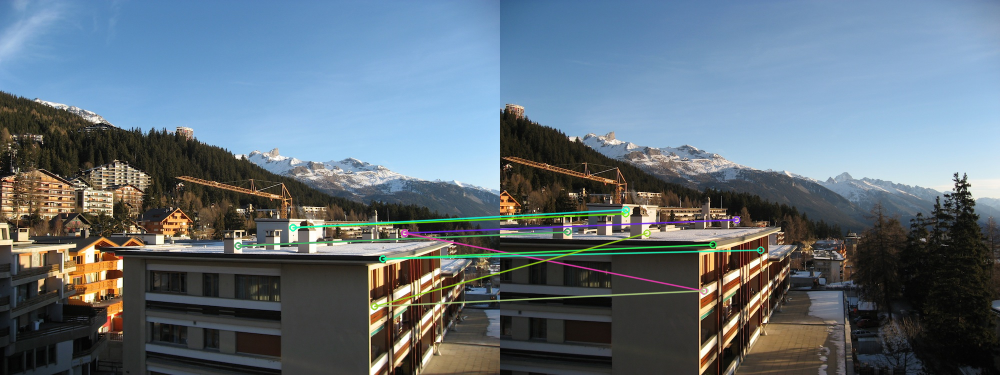

In [33]:
let mut good_sliced: opencv::core::Vector<opencv::core::Vector<opencv::core::DMatch>> = Default::default();
for i in 0..5 {
    good_sliced.push(good.get(i).unwrap());
}

let mut img_lr_knn_match_render_sliced: Mat = Default::default();
opencv::features2d::draw_matches_knn(
    &img_l_resized,
    &gray_l_surf_keypoints,
    &img_r_resized,
    &gray_r_surf_keypoints,
    &good_sliced,
    &mut img_lr_knn_match_render_sliced,
    opencv::core::Scalar::all(-1.), // match_color
    opencv::core::Scalar::all(-1.), // single_point_color,
    &match_mask,
    opencv::features2d::DrawMatchesFlags::NOT_DRAW_SINGLE_POINTS
);
opencv_imshow(&img_lr_knn_match_render_sliced)

In [ ]:
// TODO: wrap perspective